In [1]:
#run this cell only once at the beginning of measurments
#import relavent python packages
import numpy as np
import matplotlib.pyplot as plt
import seabreeze
import pandas as pd

#import spectrometer
from seabreeze.spectrometers import Spectrometer
spec = Spectrometer.from_first_available()

In [232]:
#run this every time you want to take a background sample, 
#integration time should be on the order of 1-10 seconds, make sure the actual measurment time matches this

int_time = 2000000
spec.integration_time_micros(int_time)
wavelength = spec.wavelengths()
background = spec.intensities()

<Figure size 576x288 with 0 Axes>

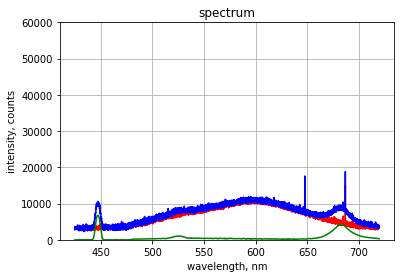

<Figure size 576x288 with 0 Axes>

In [233]:
#this should be run once the laser is turned on, it will show a plot of the raw values, as well as data processing
spec.integration_time_micros(int_time)
intensity = spec.intensities() 
df = pd.DataFrame({'wavelength' : wavelength, 'background' : background, 'intensity' : intensity})
df['difference'] = df.intensity - df.background
df['rolling'] = df.difference.rolling(11, min_periods = 1, center = True).mean()

df = df.where(425 < df.wavelength) 
df = df.where(df.wavelength < 725)


#plotting commands in matplotlib
plt.plot(df.wavelength, df.background, c='red')
plt.plot(df.wavelength, df.intensity, c='blue')
#plt.plot(df.wavelength, df.difference, c='green')
plt.plot(df.wavelength, df['rolling'], c='green')
plt.title("spectrum")
plt.ylim(0, 60000)
plt.xlabel('wavelength, nm')
plt.ylabel('intensity, counts')
plt.grid()
plt.figure(figsize=(8, 4)) 


In [2]:
df['baseline'] = df.difference.rolling(800, min_periods = 1, center = True).mean()

high = df.where(650 < df.wavelength) 
high = high.where(high.wavelength < 700)
high = high.dropna()

low = df.where(510 < df.wavelength) 
low = low.where(low.wavelength < 540)
low = low.dropna()


plt.plot(low['wavelength'], low['baseline'], ':', c='red')
plt.plot(wavelength, df['rolling'], c='green')
plt.title("Spectrum of Duck Pond Water Sample")
plt.ylim(-100, 7000)
plt.xlabel('Wavelength, nm')
plt.ylabel('Intensity, counts')
plt.grid()
plt.figure(figsize=(1, 1)) 



print('flourescense peak at: ' + str(max(high['rolling'])))
print('raman peak at: ' + str(max(low['rolling'])))
print("baseline of raman set to " + str(df['baseline'].loc[min(low.index)]))

print('raman above baseline by ' + str(max(high['rolling']) / (max(low['rolling']) - df['baseline'].loc[min(low.index)])))
#print(df.loc[min(low.index)])
print('ratio of peaks is: ' + str(max(high['rolling']) / max(low['rolling'])))


NameError: name 'df' is not defined

In [ ]:

"""
slope=(df['rolling'].loc[max(high.index)]-df['rolling'].loc[min(high.index)])/(max(high.index)-min(high.index))
intercept=df['rolling'].loc[min(high.index)]
expected=slope*35+intercept
exp=max(high['rolling'])-expected
print(exp)

slope=(df['rolling'].loc[max(low.index)]-df['rolling'].loc[min(low.index)])/(max(low.index)-min(low.index))
intercept=df['rolling'].loc[min(low.index)]
expected=slope*5+intercept
exp2=max(low['rolling'])-expected
print(exp2)
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors


def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
wavelengths = wavelength
spectrum = df['rolling']
plt.plot(wavelengths, spectrum, color='darkred')

y = np.linspace(0, 6, 100)
X,Y = np.meshgrid(wavelengths, spectrum)

extent=(np.min(wavelengths), np.max(wavelengths), np.min(y), 40000)

plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')